In [32]:
import h5py
import argparse
import numpy as np
import rasterio as rio
import tensorflow as tf
import matplotlib.pyplot as plt

In [33]:
parser = argparse.ArgumentParser(description='Sentinel Processing Wrapper')

parser.add_argument('-sim_file', type=str, dest='sim_file',
                    default='./testing_data/simulated_stack_2252.h5',
                    help='simulated file to predict')

parser.add_argument('-dem_file', type=str, dest='dem_file',
                    default='./testing_data/maduocut_2252.tif',
                    help='dem file to predict')
args = parser.parse_known_args()[0]

model_out = './trained_denoiser/model.h5'

In [34]:
class MeanPctScaler:
    def __init__(self, pctile=95):
        self.percentile = pctile
        pass

    def fit(self, X):
        self.mean_ = np.average(X)
        self.scale_ = np.percentile(np.abs(X - self.mean_), self.percentile)
        return self

    def transform(self, X):
        return (X - self.mean_)/self.scale_

    def inverse_transform(self, X):
        return X * self.scale_ + self.mean_

def unstack_dem_timeseries(X):
    dems = X[..., :1, :, :, :]
    timeseries = X[..., 1:, :, :, :]
    return dems, timeseries

def stack_dem_timeseries(dems, timeseries):
    return np.concatenate((dems, timeseries), axis=1)

def plot_data_cust(X, y, output, n=16, vm=None, cmap='RdBu'):
    vm = vm or np.max(np.abs(output))
    fig = plt.figure(constrained_layout=True, figsize=(20, 8))
    gs0 = fig.add_gridspec(1, 3)

    gs_left = gs0[0].subgridspec(4, 5)
    gs_mid = gs0[1].subgridspec(4, 5)
    gs_right = gs0[2].subgridspec(4, 5)
    # Input timesteps
    for a in range(4):
        for b in range(4):
            i = 4 * a + b
            ax = fig.add_subplot(gs_left[a, b])
            axim = ax.imshow(X[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")
    # Output deformation
    for a in range(4):
        for b in range(4):
            i = 4 * a + b
            ax = fig.add_subplot(gs_mid[a, b])
            axim = ax.imshow(output[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")
    # Target deformation
    for a in range(4):
        for b in range(4):
            i = 4 * a + b
            ax = fig.add_subplot(gs_right[a, b])
            axim = ax.imshow(y[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")
    cax = fig.add_axes([0.955, 0.075, 0.015, 0.85])
    cbar = fig.colorbar(axim, cax=cax)
    plt.text(-56, 0.4, 'Input time series', fontsize=20)
    plt.text(-36, 0.4, 'Output time series', fontsize=20)
    plt.text(-13, 0.4, 'Target time series', fontsize=20)
    fig.savefig('prediction.jpg')

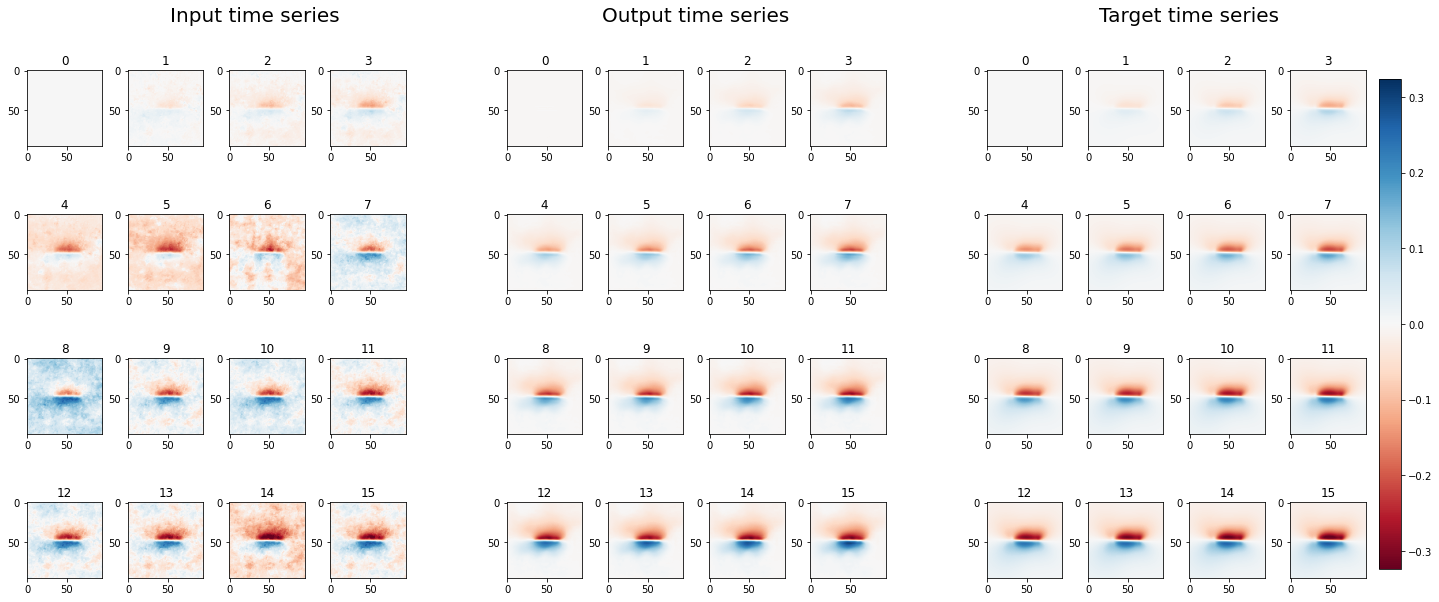

In [35]:

# Load predictive data
hf = h5py.File(args.sim_file, 'r')
defo_stack = hf['defo'][:]
strat_stack = hf['stratified'][:]
turb_stack = hf['turbulence'][:]
decor_stack = hf['decorrelation'][:]
noise = strat_stack + turb_stack + decor_stack
X_pred = defo_stack + noise*5
target_defo = defo_stack
with rio.open(args.dem_file) as src:
    dem = src.read(1).astype(np.float32)
X_pred = np.concatenate([dem[None, :, :], X_pred], axis=0)
X_pred = np.expand_dims(X_pred, 0)
X_pred = np.expand_dims(X_pred, -1)
X_pred[np.isnan(X_pred)] = 0
test_dems, test_timeseries = unstack_dem_timeseries(X_pred)
dem_scaler = MeanPctScaler().fit(test_dems)
scaled_test_dems = dem_scaler.transform(test_dems)
timeseries_scaler = MeanPctScaler().fit(test_timeseries)
scaled_test_timeseries = timeseries_scaler.transform(test_timeseries)
scaled_X_test = stack_dem_timeseries(scaled_test_dems, scaled_test_timeseries)

# Load model
autoencoder = tf.keras.models.load_model(model_out, compile=False)

# Predicition
scaled_pred = autoencoder.predict(scaled_X_test)
pred = timeseries_scaler.inverse_transform(scaled_pred)
pred = np.expand_dims(np.expand_dims(np.expand_dims(pred, axis=0), axis=0), axis=-1)
x_img = X_pred.squeeze()[1:]
targ_img = target_defo.squeeze()
y_img = pred.squeeze()
plot_data_cust(x_img, targ_img, y_img)